In [138]:
import os
from mesa_web import read_profile, read_history, find_read_profile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.optimize import minimize, curve_fit
import astropy.units as u
import astropy.constants as const
import math
import statistics
from scipy.stats import linregress
import matplotlib.pyplot as plt
import matplotlib.cm
import scipy.signal as signal
import matplotlib.patches as mpatches
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib.colors import (ListedColormap, LinearSegmentedColormap)
from matplotlib.patches import ConnectionPatch, Rectangle
from matplotlib.offsetbox import AnchoredOffsetbox, TextArea, HPacker, VPacker

## METALICIDAD SOLAR $Z \sim 0.2$, $M = 1.18 M_{\odot}$

In [2]:
# CARGAR PERFILES

mesa_z_sun_path = 'MESA_SOLAR_Z'
profiles_path = list()

for path in os.listdir(mesa_z_sun_path):
    if path.startswith('profile'):
        if path.endswith('index'):
            continue
        else:
            profiles_path.append(os.path.join(mesa_z_sun_path, path))

In [3]:
trimmed_history_star = read_history(os.path.join(mesa_z_sun_path, 'trimmed_history.data'))
trimmed_history_star

{'version_number': '"12778"',
 'compiler': '"gfortran"',
 'build': '"9.2.0"',
 'MESA_SDK_version': '"x86_64-linux-20.3.2"',
 'math_backend': '"CRMATH"',
 'date': '"20230919"',
 'burn_min1': 50.0,
 'burn_min2': 1000.0,
 'model_number': array([    1,     2,     3, ..., 16251, 16252, 16253]),
 'star_age': array([1.00000000e-05, 2.20000000e-05, 3.64000000e-05, ...,
        6.72112400e+09, 6.72112407e+09, 6.72112413e+09]),
 'star_mass': array([1.18      , 1.18      , 1.18      , ..., 1.14440066, 1.14440065,
        1.14440065]),
 'log_L': array([2.6674536 , 2.66455237, 2.66120094, ..., 2.05660195, 2.05640961,
        2.05622533]),
 'log_R': array([1.53781253, 1.53778501, 1.53775294, ..., 1.27903535, 1.27890864,
        1.27878735]),
 'log_Teff': array([3.65958655, 3.65887501, 3.65805319, ..., 3.63626223, 3.6362775 ,
        3.63629208]),
 'log_center_T': array([5.47703373, 5.47703396, 5.47703396, ..., 7.41058135, 7.40943494,
        7.40842795]),
 'log_center_Rho': array([-3.43109383, -3.43

In [4]:
trimmed_history_star = read_history(os.path.join(mesa_z_sun_path, 'trimmed_history.data'))
star_model_number = trimmed_history_star['model_number']
star_luminosity = trimmed_history_star['log_L']
star_age = np.array(trimmed_history_star['star_age']) * 10** -9
star_teff = 10 ** np.array(trimmed_history_star['log_Teff'])
star_tri_alpha = trimmed_history_star['tri_alfa']
star_cno = trimmed_history_star['cno']
star_eta = trimmed_history_star['center_degeneracy']
log_star_rho = trimmed_history_star['log_center_Rho']
log_star_pressure = trimmed_history_star['log_center_P']
log_star_central_t = trimmed_history_star['log_center_T']
star_mass_loss_rate = np.array(trimmed_history_star['star_mdot']) * 10 ** 9
star_trimmed_data = pd.DataFrame({'star_model_number': star_model_number,
                                    'star_luminosity': star_luminosity,
                                    'star_age': star_age,
                                    'star_teff': star_teff,
                                    'star_tri_alpha': star_tri_alpha,
                                    'star_cno': star_cno,
                                    'star_eta': star_eta,
                                    'log_star_rho': log_star_rho,
                                    'log_star_pressure': log_star_pressure,
                                    'log_center_T': log_star_central_t,
                                    'mass_loss_rate': star_mass_loss_rate})

star_trimmed_data

,star_model_number,star_luminosity,star_age,star_teff,star_tri_alpha,star_cno,star_eta,log_star_rho,log_star_pressure,log_center_T,mass_loss_rate
0,1,2.667454,1.000000e-14,4566.532494,-99.000000,-99.000000,-8.367673,-3.431094,10.170103,5.477034,-0.547051
1,2,2.664552,2.200000e-14,4559.056830,-99.000000,-99.000000,-8.367673,-3.431093,10.170104,5.477034,-0.543806
2,3,2.661201,3.640000e-14,4550.437831,-99.000000,-99.000000,-8.367673,-3.431093,10.170104,5.477034,-0.540151
3,4,2.657745,5.368000e-14,4541.586510,-99.000000,-99.000000,-8.367672,-3.431093,10.170104,5.477034,-0.535959
4,5,2.653556,7.441600e-14,4530.875836,-99.000000,-99.000000,-8.367672,-3.431093,10.170104,5.477034,-0.531667
...,...,...,...,...,...,...,...,...,...,...,...
16268,16249,2.056886,6.721124e+00,4327.524321,3.318383,-1.550611,19.961437,5.180056,21.131231,7.412535,-0.075823
16269,16250,2.056759,6.721124e+00,4327.626193,3.295665,-1.559986,19.960749,5.178592,21.128839,7.411614,-0.075786
16270,16251,2.056602,6.721124e+00,4327.750627,3.264676,-1.570009,19.959976,5.176953,21.126160,7.410581,-0.075749
16271,16252,2.056410,6.721124e+00,4327.902810,3.229800,-1.580562,19.959113,5.175132,21.123184,7.409435,-0.075704


DETERMINAR ZAMS CON ULTIMO MINIMO DE LUMINOSIDAD

In [5]:
local_minimums_luminosity = star_trimmed_data[(star_trimmed_data['star_luminosity'] < star_trimmed_data['star_luminosity'].shift(1)) &
                                              (star_trimmed_data['star_luminosity'] < star_trimmed_data['star_luminosity'].shift(-1))][1:2]

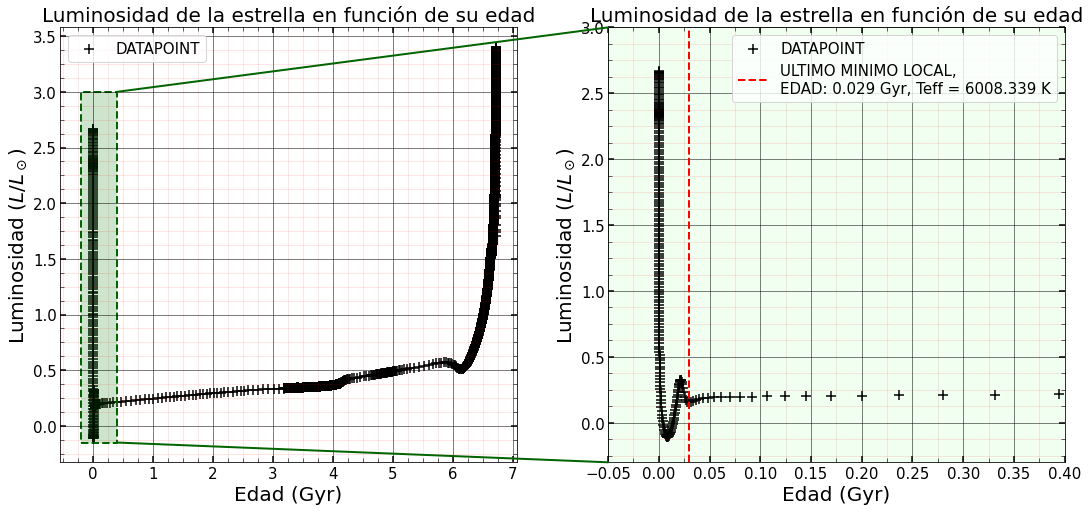

In [6]:
# graph star luminosity as a function of star age

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,8))
ax1.scatter(star_trimmed_data['star_age'], star_trimmed_data['star_luminosity'], marker="+", s=100, c='black', label='DATAPOINT')
ax1.set_xlabel('Edad (Gyr)', fontsize=20)
ax1.set_ylabel(r'Luminosidad ($L/L_\odot$)', fontsize=20)
# ax1.set_xlim(-0.09,0.5)
ax1.set_title('Luminosidad de la estrella en función de su edad', fontsize=20)

ax1.xaxis.set_minor_locator(MultipleLocator(0.25))
ax1.yaxis.set_minor_locator(MultipleLocator(0.125))

ax1.fill_between((-0.2, 0.4), -0.15, 3, facecolor='green', alpha=0.2)
ax1.add_patch(Rectangle((-0.2, -0.15), 0.6, 3.15, 
                        fc='none',
                        ec='darkgreen',
                        lw=2,
                        ls='--',)
              )


ax1.tick_params(axis='both', labelsize=15, direction='in', right=True, top=True,
              length=6, width=1.5, grid_color='black', grid_alpha=1, grid_linestyle="-",
              grid_linewidth=0.5)
ax1.tick_params(which='minor', length=4, color='black', direction='in', top=True, right=True,
                grid_alpha=0.2, grid_linewidth=0.5, grid_linestyle="-",grid_color='r')

ax1.grid(True, which='both')
ax1.legend(fontsize=15, markerscale=1)

ax2.scatter(star_trimmed_data['star_age'], star_trimmed_data['star_luminosity'], marker="+", s=100, c='black', label='DATAPOINT')
ax2.set_xlabel('Edad (Gyr)', fontsize=20)
ax2.set_ylabel(r'Luminosidad ($L/L_\odot$)', fontsize=20)
ax2.set_xlim(-0.05,0.4)
ax2.set_ylim(-0.3,3)
ax2.set_title('Luminosidad de la estrella en función de su edad', fontsize=20)

ax2.set_facecolor("honeydew")

ax2.xaxis.set_minor_locator(MultipleLocator(0.025))
ax2.yaxis.set_minor_locator(MultipleLocator(0.125))

for minimum in local_minimums_luminosity['star_age']:
    ax2.axvline(minimum, color='red', linestyle='--', linewidth=2, label='ULTIMO MINIMO LOCAL, \nEDAD: {:.3f} Gyr, Teff = {:.3f} K'.format(
        minimum, star_trimmed_data[star_trimmed_data['star_age'] == minimum]['star_teff'].values[0]))

# ax2.fill_between((-0.2, 0.4), -0.15, 3, facecolor='green', alpha=0.2)

ax2.tick_params(axis='both', labelsize=15, direction='in', right=True, top=True,
              length=6, width=1.5, grid_color='black', grid_alpha=1, grid_linestyle="-",
              grid_linewidth=0.5)
ax2.tick_params(which='minor', length=4, color='black', direction='in', top=True, right=True,
                grid_alpha=0.2, grid_linewidth=0.5, grid_linestyle="-",grid_color='r')

ax2.grid(True, which='both')
ax2.legend(fontsize=15, markerscale=1)

con1 = ConnectionPatch(xyA=(0.4, -0.15), coordsA=ax1.transData, 
                       xyB=(-0.05, -0.3), coordsB=ax2.transData, color = 'darkgreen', linestyle='-', linewidth=2)
con2 = ConnectionPatch(xyA=(0.4, 3), coordsA=ax1.transData, 
                       xyB=(-0.05, 3), coordsB=ax2.transData, color = 'darkgreen', linestyle='-', linewidth=2)
fig.add_artist(con1)
fig.add_artist(con2)




GRAFICO $\nabla, \nabla_{\text{rad}}, \nabla_{\text{ad}}$ EN ZAMS

In [7]:
age_zams_model = local_minimums_luminosity['star_model_number'][0:1] # Gyr
age_zams_model

247    248
Name: star_model_number, dtype: int32

In [8]:
local_minimums_luminosity

,star_model_number,star_luminosity,star_age,star_teff,star_tri_alpha,star_cno,star_eta,log_star_rho,log_star_pressure,log_center_T,mass_loss_rate
247,248,0.155716,0.029457,6008.338591,-45.383667,-0.413783,-1.995843,1.852279,17.154628,7.173699,-0.000054


In [9]:
zams_profile = find_read_profile(os.path.join(mesa_z_sun_path, 'profiles.index'), int(age_zams_model), nearest=True)
zams_profile

{'model_number': 250,
 'num_zones': 474,
 'initial_mass': 1.18,
 'initial_z': 0.02,
 'star_age': 33753869.98148546,
 'time_step': 2343680.105014431,
 'Teff': 6027.636987573186,
 'photosphere_L': 1.462878505050602,
 'photosphere_r': 1.1106284324958564,
 'center_eta': -1.969989852806534,
 'center_h1': 0.6988412201930622,
 'center_he3': 4.139002774511898e-05,
 'center_he4': 0.28067936594497667,
 'center_c12': 0.0014910156482336237,
 'center_n14': 0.00427341027785156,
 'center_o16': 0.011203567670773467,
 'center_ne20': 0.0025129237964844936,
 'star_mass': 1.1799962298932813,
 'star_mdot': -5.4157420783849155e-14,
 'star_mass_h1': 0.8257706347873154,
 'star_mass_he3': 8.645423347950818e-05,
 'star_mass_he4': 0.3304812352858099,
 'star_mass_c12': 0.004512950578107467,
 'star_mass_n14': 0.0018298383587021499,
 'star_mass_o16': 0.013220494052169787,
 'star_mass_ne20': 0.0029652406058608125,
 'he_core_mass': 0.0,
 'c_core_mass': 0.0,
 'o_core_mass': 0.0,
 'si_core_mass': 0.0,
 'fe_core_mass': 

In [123]:
def multicolor_ylabel(ax,list_of_strings,list_of_colors,axis='x',anchorpad=0,**kw):
    """this function creates axes labels with multiple colors
    ax specifies the axes object where the labels should be drawn
    list_of_strings is a list of all of the text items
    list_if_colors is a corresponding list of colors for the strings
    axis='x', 'y', or 'both' and specifies which label(s) should be drawn"""

    # x-axis label
    if axis=='x' or axis=='both':
        boxes = [TextArea(text, textprops=dict(color=color, ha='left',va='bottom',**kw)) 
                    for text,color in zip(list_of_strings,list_of_colors) ]
        xbox = HPacker(children=boxes,align="center",pad=0, sep=5)
        anchored_xbox = AnchoredOffsetbox(loc=3, child=xbox, pad=anchorpad,frameon=False,bbox_to_anchor=(0.2, -0.09),
                                          bbox_transform=ax.transAxes, borderpad=0.)
        ax.add_artist(anchored_xbox)

    # y-axis label
    if axis=='y' or axis=='both':
        boxes = [TextArea(text, textprops=dict(color=color, ha='left',va='bottom',rotation=90,**kw)) 
                     for text,color in zip(list_of_strings[::-1],list_of_colors) ]
        ybox = VPacker(children=boxes,align="center", pad=0, sep=5)
        anchored_ybox = AnchoredOffsetbox(loc=3, child=ybox, pad=anchorpad, frameon=False, bbox_to_anchor=(-0.10, 0.35), 
                                          bbox_transform=ax.transAxes, borderpad=0.)
        ax.add_artist(anchored_ybox)

In [83]:
multicolor_ylabel(ax, (r'$\nabla$',',',r'$\nabla_{ad}$',',',r'$\nabla_{rad}$'),('g','k','b','k','r'),
                  axis='y',size=20, weight='bold', anchorpad=0)

C:\Users\56974\AppData\Local\Temp\ipykernel_16216\927439759.py:26: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  extra_legend_1 = mpatches.Patch(label='EDAD = {:.3f} Gyr'.format(float(local_minimums_luminosity['star_age'][0:1])), color='none', linestyle='--', linewidth=2, edgecolor='red')


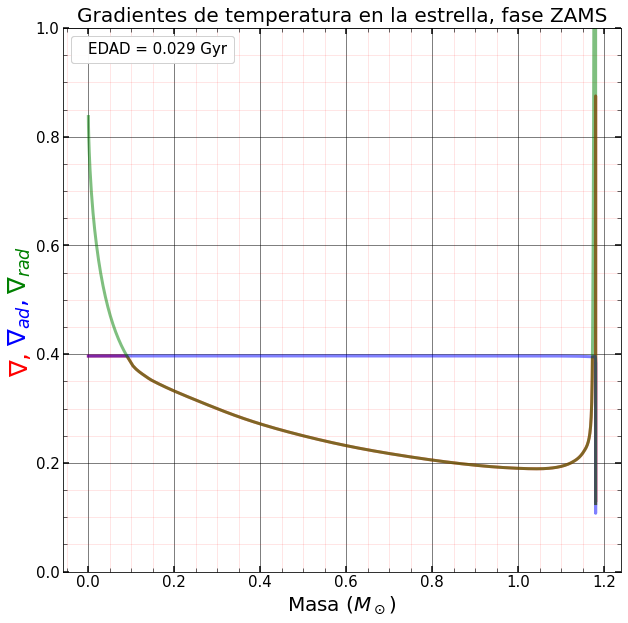

In [174]:
fig, ax = plt.subplots(figsize=(10,10))

ax.plot(zams_profile['mass'], zams_profile['gradT'], linewidth=3, c='red', alpha=0.7)
ax.plot(zams_profile['mass'], zams_profile['grada'], linewidth=3, c='blue', alpha=0.5)
ax.plot(zams_profile['mass'], zams_profile['gradr'], linewidth=3, c='green', alpha=0.5)
ax.set_ylim(0,1)

ax.set_title('Gradientes de temperatura en la estrella, fase ZAMS', fontsize=20)

ax.set_xlabel(r'Masa ($M_\odot$)', fontsize=20)

multicolor_ylabel(ax, (r'$\nabla$,',r'$\nabla_{ad}$,',r'$\nabla_{rad}$'),('g','b','r'),
                  axis='y',size=25, anchorpad=0)

ax.tick_params(axis='both', labelsize=15, direction='in', right=True, top=True,
              length=6, width=1.5, grid_color='black', grid_alpha=1, grid_linestyle="-",
              grid_linewidth=0.5)
ax.tick_params(which='minor', length=4, color='black', direction='in', top=True, right=True,
                grid_alpha=0.2, grid_linewidth=0.5, grid_linestyle="-",grid_color='r')

ax.xaxis.set_minor_locator(MultipleLocator(0.05))
ax.yaxis.set_minor_locator(MultipleLocator(0.05))

ax.grid(True, which='both')

extra_legend_1 = mpatches.Patch(label='EDAD = {:.3f} Gyr'.format(float(local_minimums_luminosity['star_age'][0:1])), color='none', linestyle='--', linewidth=2, edgecolor='red')

handles, labels = ax.get_legend_handles_labels()
handles.append(extra_legend_1)
extra_legend = ax.legend(handles=[extra_legend_1], loc='upper left', bbox_to_anchor=(0.0, 1.0), fontsize=15, markerscale=0, handlelength=0)
extra_legend.legendHandles[0].set_visible(False)

ax.add_artist(extra_legend)

# ax.legend(fontsize=15, markerscale=1)

# ax.set_ylabel(r'Masa ($M_\odot$)', fontsize=20)

In [167]:
vconv_zams = zams_profile['conv_vel'] / 100 # m/s

C:\Users\56974\AppData\Local\Temp\ipykernel_16216\3201049548.py:20: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  extra_legend_1 = mpatches.Patch(label='EDAD = {:.3f} Gyr'.format(float(local_minimums_luminosity['star_age'][0:1])), color='none', linestyle='--', linewidth=2, edgecolor='red')


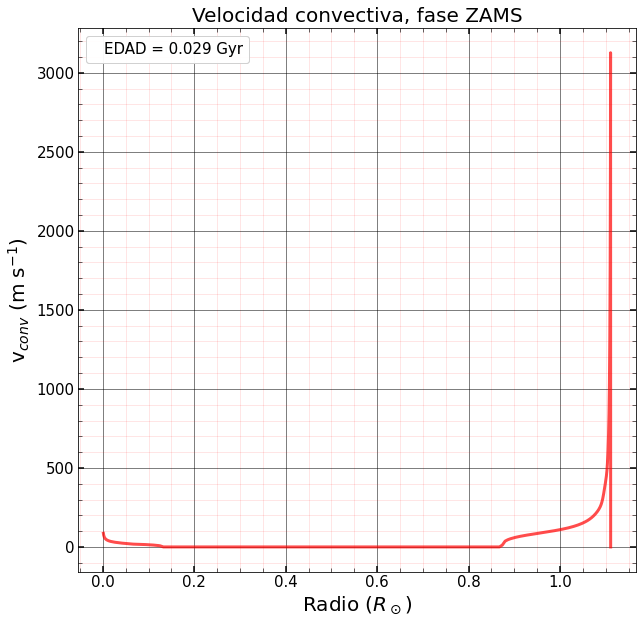

In [178]:
fig, ax = plt.subplots(figsize=(10,10))

ax.plot(zams_profile['radius'], vconv_zams, linewidth=3, c='red', alpha=0.7)

ax.set_title('Velocidad convectiva, fase ZAMS', fontsize=20)
ax.set_xlabel(r'Radio ($R_\odot$)', fontsize=20)
ax.set_ylabel(r'v$_{conv}$ (m s$^{-1}$)', fontsize=20)

ax.tick_params(axis='both', labelsize=15, direction='in', right=True, top=True,
              length=6, width=1.5, grid_color='black', grid_alpha=1, grid_linestyle="-",
              grid_linewidth=0.5)
ax.tick_params(which='minor', length=4, color='black', direction='in', top=True, right=True,
                grid_alpha=0.2, grid_linewidth=0.5, grid_linestyle="-",grid_color='r')

ax.xaxis.set_minor_locator(MultipleLocator(0.05))
ax.yaxis.set_minor_locator(MultipleLocator(100))

ax.grid(True, which='both')

extra_legend_1 = mpatches.Patch(label='EDAD = {:.3f} Gyr'.format(float(local_minimums_luminosity['star_age'][0:1])), color='none', linestyle='--', linewidth=2, edgecolor='red')

handles, labels = ax.get_legend_handles_labels()
handles.append(extra_legend_1)
extra_legend = ax.legend(handles=[extra_legend_1], loc='upper left', bbox_to_anchor=(0.0, 1.0), fontsize=15, markerscale=0, handlelength=0)
extra_legend.legendHandles[0].set_visible(False)

ax.add_artist(extra_legend)

# ax.legend(fontsize=15, markerscale=1)

DETERMINAR TRGB CON COMIENZO DE REACCIONES TRIPLE ALFA

In [12]:
# determine when the tri_alpha becomes positive

tri_alpha_start = star_trimmed_data[star_trimmed_data['star_tri_alpha'] > 0][0:1]
tri_alpha_start

,star_model_number,star_luminosity,star_age,star_teff,star_tri_alpha,star_cno,star_eta,log_star_rho,log_star_pressure,log_center_T,mass_loss_rate
15320,15302,3.373418,6.720736,3257.368458,0.000424,3.36898,19.735778,5.914688,22.313712,7.874318,-12.584586


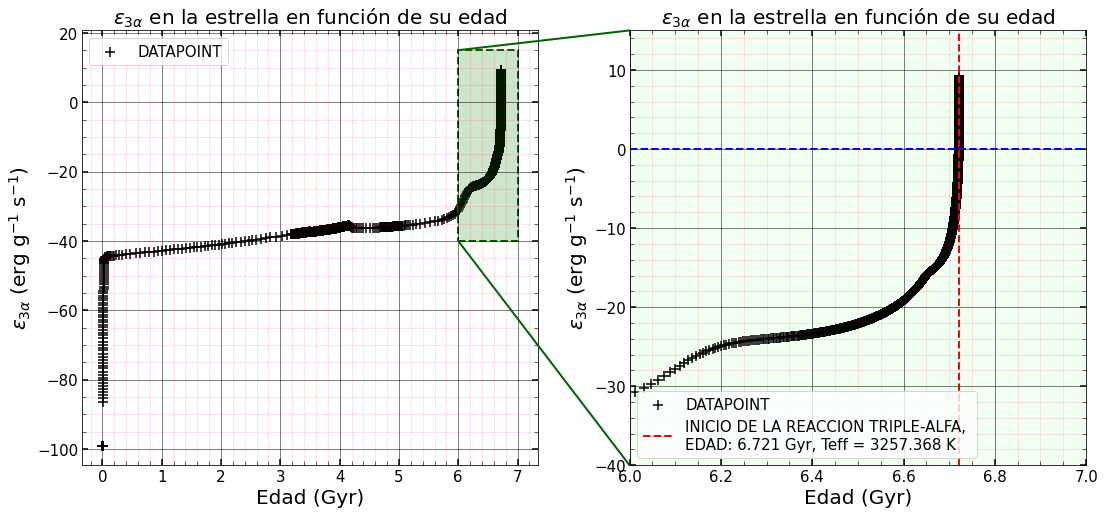

In [13]:
# graph star tri_alpha as a function of star age

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,8))

ax1.scatter(star_trimmed_data['star_age'], star_trimmed_data['star_tri_alpha'], marker="+", s=100, c='black', label='DATAPOINT')
ax1.set_xlabel('Edad (Gyr)', fontsize=20)
ax1.set_ylabel(r'$\epsilon_{3\alpha}$ (erg g$^{-1}$ s$^{-1}$)', fontsize=20)
# ax.set_xlim(-0.05,0.4)
# ax.set_ylim(-0.05,0.4)

ax1.set_title(r'$\epsilon_{3\alpha}$ en la estrella en función de su edad', fontsize=20)

ax1.fill_between((6, 7), -40, 15, facecolor='green', alpha=0.2)
ax1.add_patch(Rectangle((6, -40), 1, 55, 
                        fc='none',
                        ec='darkgreen',
                        lw=2,
                        ls='--',)
              )
# ax1.set_facecolor("honeydew")

ax1.xaxis.set_minor_locator(MultipleLocator(0.2))
ax1.yaxis.set_minor_locator(MultipleLocator(5))

ax1.tick_params(axis='both', labelsize=15, direction='in', right=True, top=True,
                length=6, width=1.5, grid_color='black', grid_alpha=1, grid_linestyle="-",
                grid_linewidth=0.5)
ax1.tick_params(which='minor', length=4, color='black', direction='in', top=True, right=True,
                grid_alpha=0.2, grid_linewidth=0.5, grid_linestyle="-",grid_color='r')

ax1.grid(True, which='both')
ax1.legend(fontsize=15, markerscale=1)

ax2.scatter(star_trimmed_data['star_age'], star_trimmed_data['star_tri_alpha'], marker="+", s=100, c='black', label='DATAPOINT')
ax2.set_xlabel('Edad (Gyr)', fontsize=20)
ax2.set_ylabel(r'$\epsilon_{3\alpha}$ (erg g$^{-1}$ s$^{-1}$)', fontsize=20)
ax2.set_xlim(6,7)
ax2.set_ylim(-40,15)

ax2.set_title(r'$\epsilon_{3\alpha}$ en la estrella en función de su edad', fontsize=20)

ax2.set_facecolor("honeydew")

ax2.xaxis.set_minor_locator(MultipleLocator(0.05))
ax2.yaxis.set_minor_locator(MultipleLocator(2))

ax2.tick_params(axis='both', labelsize=15, direction='in', right=True, top=True,
                length=6, width=1.5, grid_color='black', grid_alpha=1, grid_linestyle="-",
                grid_linewidth=0.5)
ax2.tick_params(which='minor', length=4, color='black', direction='in', top=True, right=True,
                grid_alpha=0.2, grid_linewidth=0.5, grid_linestyle="-",grid_color='r')

ax2.grid(True, which='both')


con1 = ConnectionPatch(xyA=(6, -40), coordsA=ax1.transData, 
                       xyB=(6, -40), coordsB=ax2.transData, color = 'darkgreen', linestyle='-', linewidth=2)
con2 = ConnectionPatch(xyA=(6, 15), coordsA=ax1.transData, 
                       xyB=(6, 15), coordsB=ax2.transData, color = 'darkgreen', linestyle='-', linewidth=2)


fig.add_artist(con1)
fig.add_artist(con2)


ax2.axhline(0, color='blue', linestyle='--', linewidth=2)
ax2.axvline(np.array(tri_alpha_start['star_age']), color='red', linestyle='--', linewidth=2, label='INICIO DE LA REACCION TRIPLE-ALFA, \nEDAD: {:.3f} Gyr, Teff = {:.3f} K'.format(np.array(tri_alpha_start['star_age'])[0], np.array(tri_alpha_start['star_teff'])[0]))
ax2.legend(fontsize=15, markerscale=1)

In [154]:
trgb_profile = find_read_profile(os.path.join(mesa_z_sun_path, 'profiles.index'), int(tri_alpha_start['star_model_number']), nearest=True)
trgb_profile

{'model_number': 15300,
 'num_zones': 949,
 'initial_mass': 1.18,
 'initial_z': 0.02,
 'star_age': 6720735225.266381,
 'time_step': 366.18832557299567,
 'Teff': 3257.5312953295866,
 'photosphere_L': 2361.6424518313,
 'photosphere_r': 152.78781371579154,
 'center_eta': 19.735404213602006,
 'center_h1': 0.0,
 'center_he3': 0.0,
 'center_he4': 0.9802495995891104,
 'center_c12': 7.764452149446407e-05,
 'center_n14': 0.01243915731135238,
 'center_o16': 0.003763199303213904,
 'center_ne20': 0.0025132928339514317,
 'star_mass': 1.147042471969241,
 'star_mdot': -1.2582100195057573e-08,
 'star_mass_h1': 0.4688194785406006,
 'star_mass_he3': 0.0006442136061715434,
 'star_mass_he4': 0.6547646368238155,
 'star_mass_c12': 0.002368186557834575,
 'star_mass_n14': 0.007918670060451678,
 'star_mass_o16': 0.00854636478499215,
 'star_mass_ne20': 0.002883079857504452,
 'he_core_mass': 0.45725839143462843,
 'c_core_mass': 0.0,
 'o_core_mass': 0.0,
 'si_core_mass': 0.0,
 'fe_core_mass': 0.0,
 'neutron_rich_

C:\Users\56974\AppData\Local\Temp\ipykernel_16216\3998666447.py:26: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  extra_legend_1 = mpatches.Patch(label='EDAD = {:.3f} Gyr'.format(float(tri_alpha_start['star_age'][0:1])), color='none', linestyle='--', linewidth=2, edgecolor='red')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


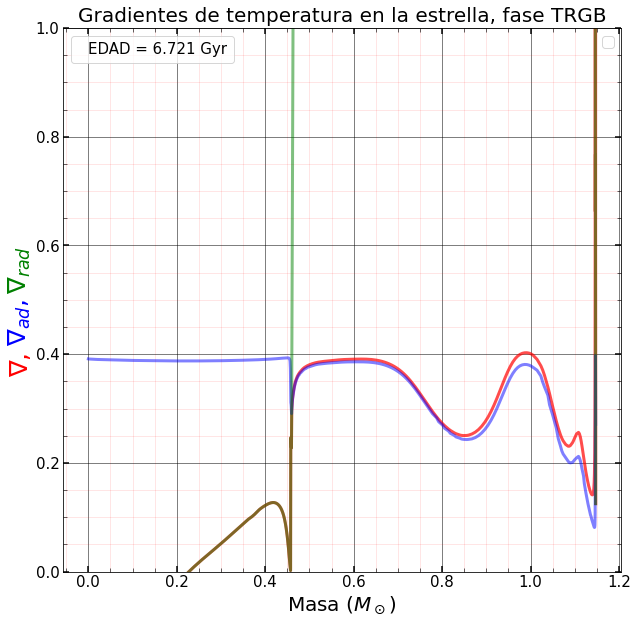

In [155]:
fig, ax = plt.subplots(figsize=(10,10))

ax.plot(trgb_profile['mass'], trgb_profile['gradT'], linewidth=3, c='red', alpha=0.7)
ax.plot(trgb_profile['mass'], trgb_profile['grada'], linewidth=3, c='blue', alpha=0.5)
ax.plot(trgb_profile['mass'], trgb_profile['gradr'], linewidth=3, c='green', alpha=0.5)
ax.set_ylim(0,1)

ax.set_title('Gradientes de temperatura en la estrella, fase TRGB', fontsize=20)

ax.set_xlabel(r'Masa ($M_\odot$)', fontsize=20)

multicolor_ylabel(ax, (r'$\nabla$,',r'$\nabla_{ad}$,',r'$\nabla_{rad}$'),('g','b','r'),
                  axis='y',size=25, anchorpad=0)

ax.tick_params(axis='both', labelsize=15, direction='in', right=True, top=True,
              length=6, width=1.5, grid_color='black', grid_alpha=1, grid_linestyle="-",
              grid_linewidth=0.5)
ax.tick_params(which='minor', length=4, color='black', direction='in', top=True, right=True,
                grid_alpha=0.2, grid_linewidth=0.5, grid_linestyle="-",grid_color='r')

ax.xaxis.set_minor_locator(MultipleLocator(0.05))
ax.yaxis.set_minor_locator(MultipleLocator(0.05))

ax.grid(True, which='both')

extra_legend_1 = mpatches.Patch(label='EDAD = {:.3f} Gyr'.format(float(tri_alpha_start['star_age'][0:1])), color='none', linestyle='--', linewidth=2, edgecolor='red')

handles, labels = ax.get_legend_handles_labels()
handles.append(extra_legend_1)
extra_legend = ax.legend(handles=[extra_legend_1], loc='upper left', bbox_to_anchor=(0.0, 1.0), fontsize=15, markerscale=0, handlelength=0)
extra_legend.legendHandles[0].set_visible(False)

ax.add_artist(extra_legend)

ax.legend(fontsize=15, markerscale=1)

In [182]:
vconv_trgb = trgb_profile['conv_vel'] / 100 # m/s

C:\Users\56974\AppData\Local\Temp\ipykernel_16216\3768311800.py:20: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  extra_legend_1 = mpatches.Patch(label='EDAD = {:.3f} Gyr'.format(float(tri_alpha_start['star_age'][0:1])), color='none', linestyle='--', linewidth=2, edgecolor='red')


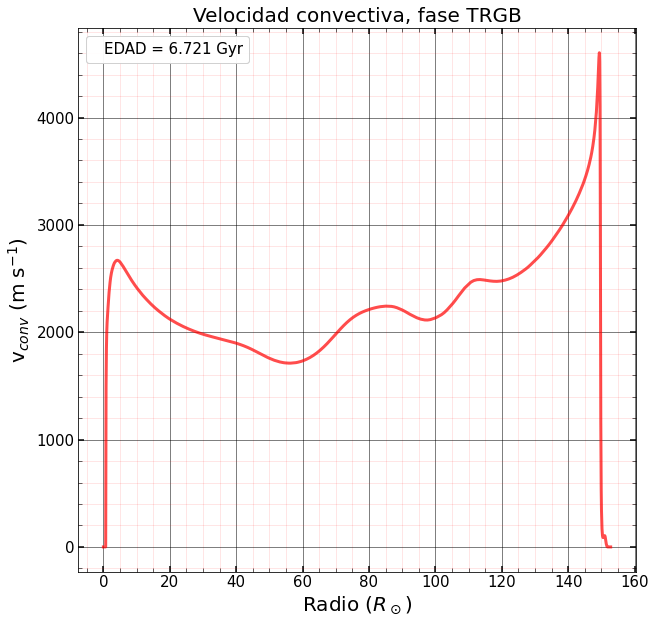

In [188]:
fig, ax = plt.subplots(figsize=(10,10))

ax.plot(trgb_profile['radius'], vconv_trgb, linewidth=3, c='red', alpha=0.7)

ax.set_title('Velocidad convectiva, fase TRGB', fontsize=20)
ax.set_xlabel(r'Radio ($R_\odot$)', fontsize=20)
ax.set_ylabel(r'v$_{conv}$ (m s$^{-1}$)', fontsize=20)

ax.tick_params(axis='both', labelsize=15, direction='in', right=True, top=True,
              length=6, width=1.5, grid_color='black', grid_alpha=1, grid_linestyle="-",
              grid_linewidth=0.5)
ax.tick_params(which='minor', length=4, color='black', direction='in', top=True, right=True,
                grid_alpha=0.2, grid_linewidth=0.5, grid_linestyle="-",grid_color='r')

ax.xaxis.set_minor_locator(MultipleLocator(5))
ax.yaxis.set_minor_locator(MultipleLocator(200))

ax.grid(True, which='both')

extra_legend_1 = mpatches.Patch(label='EDAD = {:.3f} Gyr'.format(float(tri_alpha_start['star_age'][0:1])), color='none', linestyle='--', linewidth=2, edgecolor='red')

handles, labels = ax.get_legend_handles_labels()
handles.append(extra_legend_1)
extra_legend = ax.legend(handles=[extra_legend_1], loc='upper left', bbox_to_anchor=(0.0, 1.0), fontsize=15, markerscale=0, handlelength=0)
extra_legend.legendHandles[0].set_visible(False)

ax.add_artist(extra_legend)

DETERMINAR ZAHB POR COMPORTAMIENTO DE DEGENERANCIA DE ELECTRONES

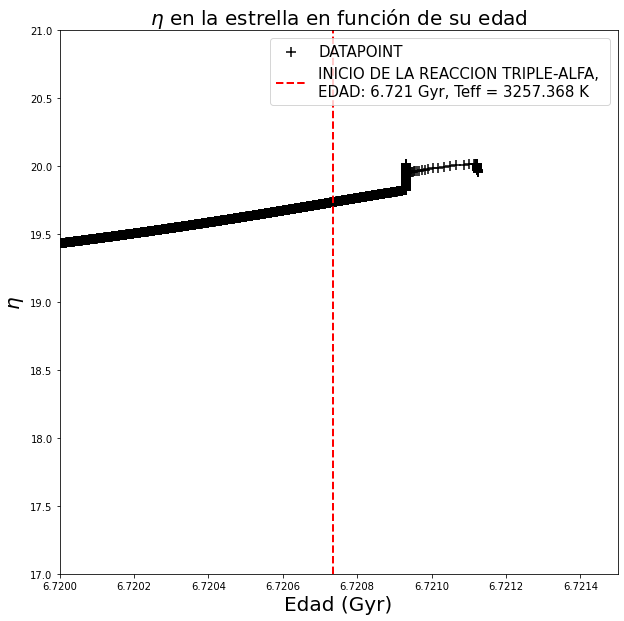

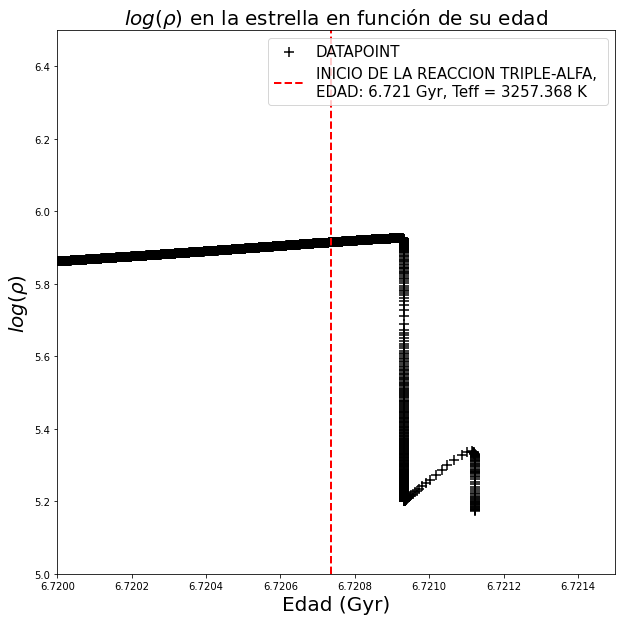

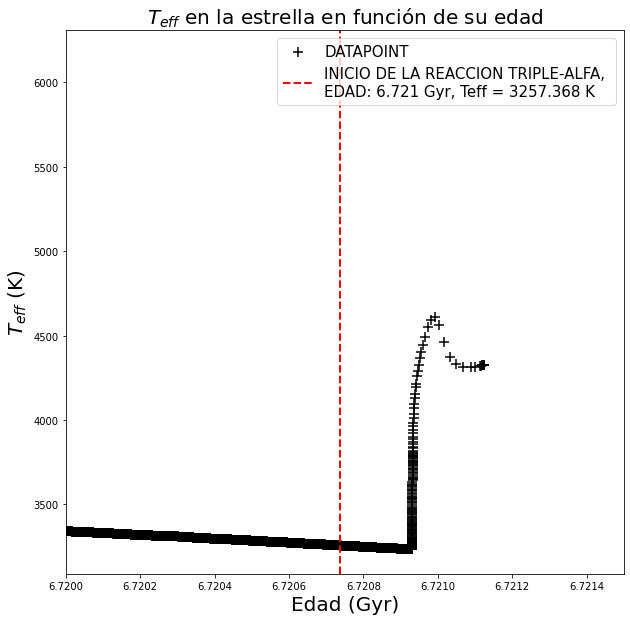

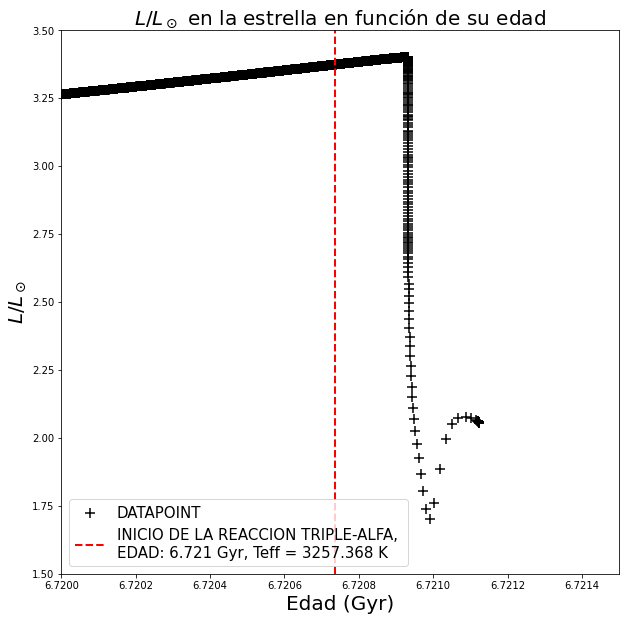

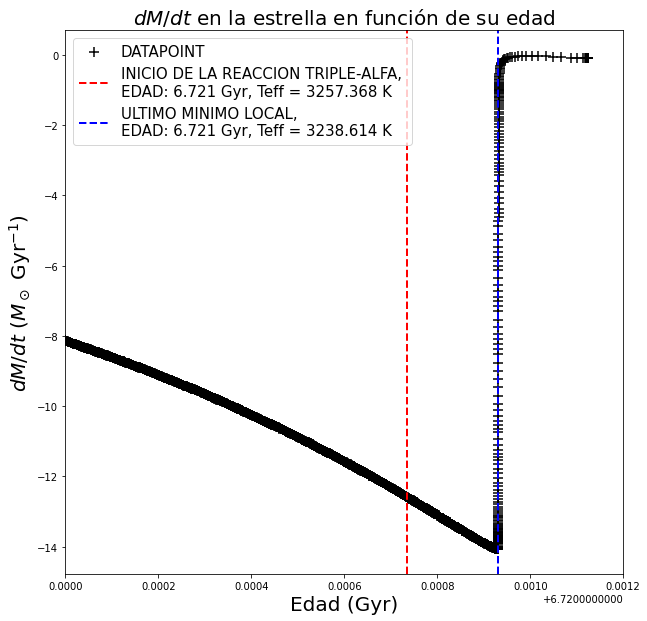

In [14]:
# GRAPH STAR ETA AS A FUNCTION OF STAR AGE, FROM THE BEGINNING OF THE TRI_ALPHA REACTION

fig, ax1 = plt.subplots(figsize=(10,10))

ax1.scatter(star_trimmed_data['star_age'], star_trimmed_data['star_eta'], marker="+", s=100, c='black', label='DATAPOINT')
ax1.set_xlabel('Edad (Gyr)', fontsize=20)
ax1.set_ylabel(r'$\eta$', fontsize=20)
ax1.set_xlim(6.72,6.7215)
ax1.set_ylim(17, 21)

ax1.axvline(np.array(tri_alpha_start['star_age']), color='red', linestyle='--', linewidth=2,
            label='INICIO DE LA REACCION TRIPLE-ALFA, \nEDAD: {:.3f} Gyr, Teff = {:.3f} K'.format(
                np.array(tri_alpha_start['star_age'])[0], np.array(tri_alpha_start['star_teff'])[0]))

ax1.set_title(r'$\eta$ en la estrella en función de su edad', fontsize=20)
ax1.legend(fontsize=15, markerscale=1)

# GRAPH DENSITY AS A FUNCTION OF STAR AGE, FROM THE BEGINNING OF THE TRI_ALPHA REACTION

fig, ax1 = plt.subplots(figsize=(10,10))

ax1.scatter(star_trimmed_data['star_age'], star_trimmed_data['log_star_rho'], marker="+", s=100, c='black', label='DATAPOINT')
ax1.set_xlabel('Edad (Gyr)', fontsize=20)
ax1.set_ylabel(r'$log(\rho)$', fontsize=20)
ax1.set_xlim(6.72,6.7215)
ax1.set_ylim(5, 6.5)

ax1.axvline(np.array(tri_alpha_start['star_age']), color='red', linestyle='--', linewidth=2,
            label='INICIO DE LA REACCION TRIPLE-ALFA, \nEDAD: {:.3f} Gyr, Teff = {:.3f} K'.format(
                np.array(tri_alpha_start['star_age'])[0], np.array(tri_alpha_start['star_teff'])[0]))

ax1.set_title(r'$log(\rho)$ en la estrella en función de su edad', fontsize=20)
ax1.legend(fontsize=15, markerscale=1)

# GRAPH TEFF AS A FUNCTION OF STAR AGE, FROM THE BEGINNING OF THE TRI_ALPHA REACTION

fig, ax1 = plt.subplots(figsize=(10,10))

ax1.scatter(star_trimmed_data['star_age'], star_trimmed_data['star_teff'], marker="+", s=100, c='black', label='DATAPOINT')
ax1.set_xlabel('Edad (Gyr)', fontsize=20)
ax1.set_ylabel(r'$T_{eff}$ (K)', fontsize=20)
ax1.set_xlim(6.72,6.7215)
# ax1.set_ylim(1.5*10**7, 2*10**7)

ax1.axvline(np.array(tri_alpha_start['star_age']), color='red', linestyle='--', linewidth=2,
            label='INICIO DE LA REACCION TRIPLE-ALFA, \nEDAD: {:.3f} Gyr, Teff = {:.3f} K'.format(
                np.array(tri_alpha_start['star_age'])[0], np.array(tri_alpha_start['star_teff'])[0]))

ax1.set_title(r'$T_{eff}$ en la estrella en función de su edad', fontsize=20)
ax1.legend(fontsize=15, markerscale=1)

# GRAPH LUMINOSITY AS A FUNCTION OF STAR AGE, FROM THE BEGINNING OF THE TRI_ALPHA REACTION

fig, ax1 = plt.subplots(figsize=(10,10))

ax1.scatter(star_trimmed_data['star_age'], star_trimmed_data['star_luminosity'], marker="+", s=100, c='black', label='DATAPOINT')
ax1.set_xlabel('Edad (Gyr)', fontsize=20)
ax1.set_ylabel(r'$L/L_\odot$', fontsize=20)
ax1.set_xlim(6.72,6.7215)
ax1.set_ylim(1.5, 3.5)

ax1.axvline(np.array(tri_alpha_start['star_age']), color='red', linestyle='--', linewidth=2,
            label='INICIO DE LA REACCION TRIPLE-ALFA, \nEDAD: {:.3f} Gyr, Teff = {:.3f} K'.format(
                np.array(tri_alpha_start['star_age'])[0], np.array(tri_alpha_start['star_teff'])[0]))

ax1.set_title(r'$L/L_\odot$ en la estrella en función de su edad', fontsize=20)
ax1.legend(fontsize=15, markerscale=1)

# GRAPH MASS LOSS RATE AS A FUNCTION OF STAR AGE, FROM THE BEGINNING OF THE TRI_ALPHA REACTION

fig, ax1 = plt.subplots(figsize=(10,10))

ax1.scatter(star_trimmed_data['star_age'], star_trimmed_data['mass_loss_rate'], marker="+", s=100, c='black', label='DATAPOINT')
ax1.set_xlabel('Edad (Gyr)', fontsize=20)
ax1.set_ylabel(r'$d{M}/dt$ ($M_\odot$ Gyr$^{-1}$)', fontsize=20)
ax1.set_xlim(6.72,6.7212)
# ax1.set_ylim(0, 10**-7)

ax1.axvline(np.array(tri_alpha_start['star_age']), color='red', linestyle='--', linewidth=2,
            label='INICIO DE LA REACCION TRIPLE-ALFA, \nEDAD: {:.3f} Gyr, Teff = {:.3f} K'.format(
                np.array(tri_alpha_start['star_age'])[0], np.array(tri_alpha_start['star_teff'])[0]))

# find the local minimum of the mass loss rate within given xlim

local_minimums_mass_loss_rate = star_trimmed_data[(star_trimmed_data['mass_loss_rate'] < star_trimmed_data['mass_loss_rate'].shift(1)) &
                                                    (star_trimmed_data['mass_loss_rate'] < star_trimmed_data['mass_loss_rate'].shift(-1))][-2:-1]

for minimum in local_minimums_mass_loss_rate['star_age']:   
    ax1.axvline(minimum, color='blue', linestyle='--', linewidth=2, label='ULTIMO MINIMO LOCAL, \nEDAD: {:.3f} Gyr, Teff = {:.3f} K'.format(
        minimum, star_trimmed_data[star_trimmed_data['star_age'] == minimum]['star_teff'].values[0])) 

ax1.set_title(r'$d{M}/dt$ en la estrella en función de su edad', fontsize=20)
ax1.legend(fontsize=15, markerscale=1, loc='upper left')





In [15]:
local_minimums_mass_loss_rate

,star_model_number,star_luminosity,star_age,star_teff,star_tri_alpha,star_cno,star_eta,log_star_rho,log_star_pressure,log_center_T,mass_loss_rate
15957,15938,3.397282,6.720932,3238.614173,7.991867,-0.545302,20.012647,5.492722,21.639246,7.609414,-13.865611


In [16]:
# find the index where local_minimums_mass_loss_rate[0:1]['star_age'] is located in star_trimmed_data['star_age']

star_trimmed_data[star_trimmed_data['star_age'] == np.array(local_minimums_mass_loss_rate['star_age'])[0]]


,star_model_number,star_luminosity,star_age,star_teff,star_tri_alpha,star_cno,star_eta,log_star_rho,log_star_pressure,log_center_T,mass_loss_rate
15957,15938,3.397282,6.720932,3238.614173,7.991867,-0.545302,20.012647,5.492722,21.639246,7.609414,-13.865611


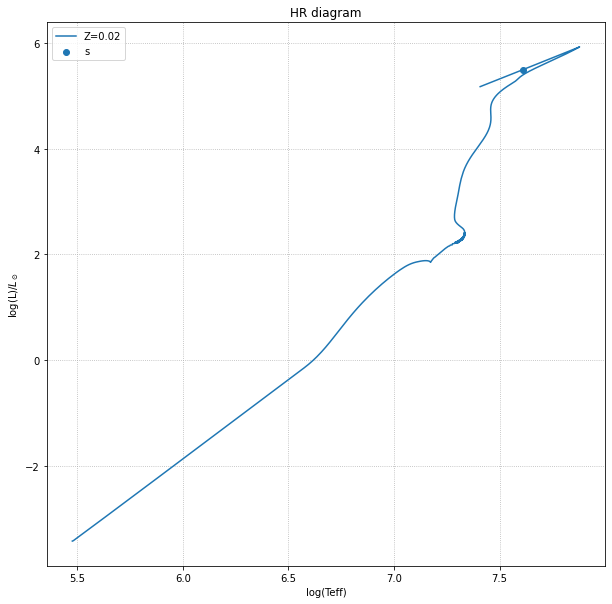

In [17]:
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(star_trimmed_data['log_center_T'], 
        star_trimmed_data['log_star_rho'], label='Z=0.02')
ax.set_xlabel('log(Teff)')
ax.set_ylabel('log(L)/$L_\odot$')
# ax.invert_xaxis()

ax.scatter(star_trimmed_data[star_trimmed_data['star_age'] == np.array(local_minimums_mass_loss_rate['star_age'])[0]]['log_center_T'],
           star_trimmed_data[star_trimmed_data['star_age'] == np.array(local_minimums_mass_loss_rate['star_age'])[0]]['log_star_rho'], label='s')

ax.set_title('HR diagram')
ax.legend()
ax.grid(linestyle='dotted')

# MESA_3718

In [18]:
mesa_3718_path = 'MESA_3718_MASS'
trimmed_history_3718 = read_history(os.path.join(mesa_3718_path, 'trimmed_history.data'))
trimmed_history_3718['star_age'] = np.array(trimmed_history_3718['star_age']) * 10** -9
trimmed_history_3718

{'version_number': '"12778"',
 'compiler': '"gfortran"',
 'build': '"9.2.0"',
 'MESA_SDK_version': '"x86_64-linux-20.3.2"',
 'math_backend': '"CRMATH"',
 'date': '"20231013"',
 'burn_min1': 50.0,
 'burn_min2': 1000.0,
 'model_number': array([    1,     2,     3, ..., 12695, 12696, 12697]),
 'star_age': array([1.00000000e-14, 2.20000000e-14, 3.64000000e-14, ...,
        2.40704964e-01, 2.40704966e-01, 2.40704969e-01]),
 'star_mass': array([3.718     , 3.718     , 3.718     , ..., 3.6620707 , 3.66206996,
        3.66206927]),
 'log_L': array([3.44237416, 3.44068942, 3.43875584, ..., 3.92789718, 3.92101738,
        3.91402463]),
 'log_R': array([2.00682904, 2.00681811, 2.00680549, ..., 2.42196563, 2.41740792,
        2.41292421]),
 'log_Teff': array([3.61880844, 3.61839272, 3.61791563, ..., 3.5326209 , 3.5331798 ,
        3.53367347]),
 'log_center_T': array([5.47697617, 5.4769761 , 5.47697571, ..., 8.02451929, 8.02450909,
        8.02450012]),
 'log_center_Rho': array([-4.40379329, -4.40

Text(0.5, 1.0, 'Diagrama de Hertzsprung-Russell')

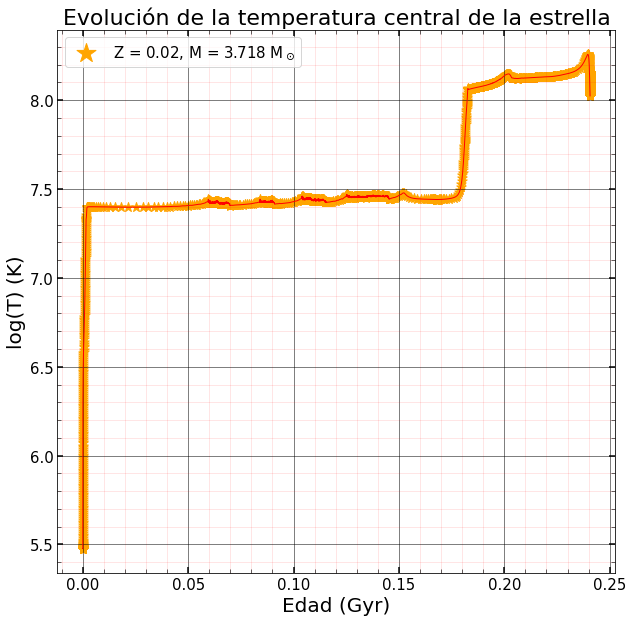

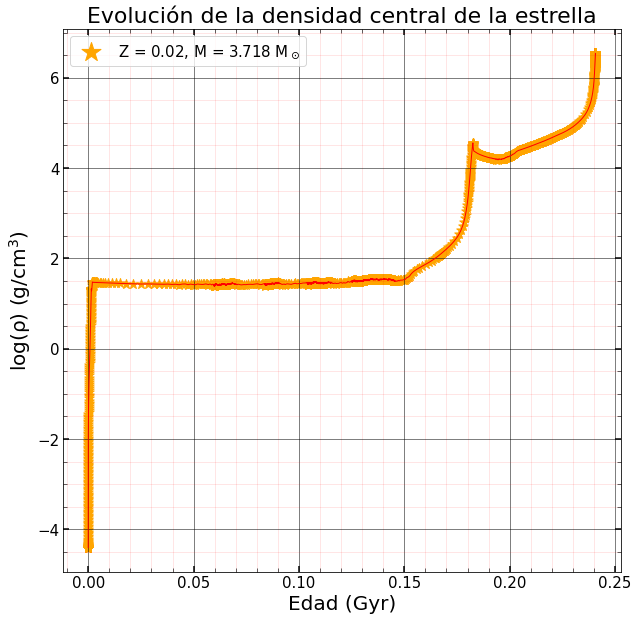

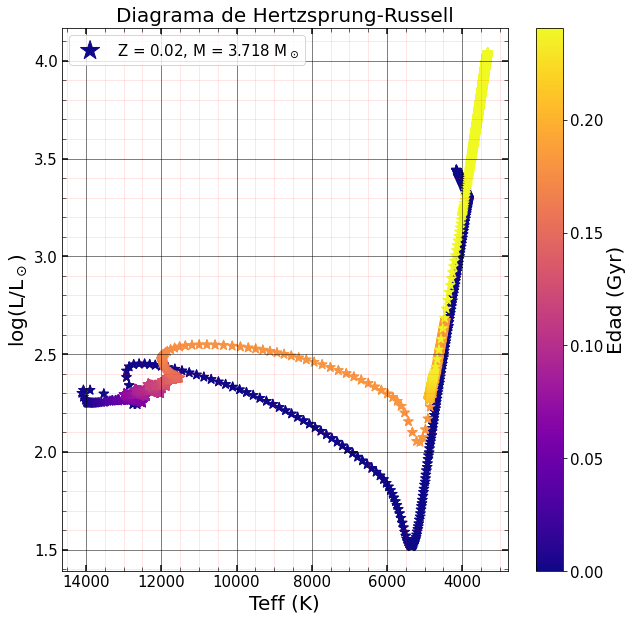

In [19]:
# graph of the evolution of the central temperature of the sunlike star

fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(trimmed_history_3718['star_age'], trimmed_history_3718['log_center_T'], marker="*", s=100, c='orange', label=r'Z = 0.02, M = 3.718 M$_\odot$')
# slim plot over it
ax.plot(trimmed_history_3718['star_age'], trimmed_history_3718['log_center_T'], c='red', linewidth=1)

ax.set_xlabel('Edad (Gyr)', fontsize=20)
ax.xaxis.set_minor_locator(MultipleLocator(0.01))
ax.yaxis.set_minor_locator(MultipleLocator(0.1))

ax.tick_params(axis='both', labelsize=15, direction='in', right=True, top=True,
              length=6, width=1.5, grid_color='black', grid_alpha=1, grid_linestyle="-",
              grid_linewidth=0.5)

ax.tick_params(which='minor', length=4, color='black', direction='in', top=True, right=True,
                grid_alpha=0.2, grid_linewidth=0.5, grid_linestyle="-",grid_color='r')

ax.grid(True, which='both')
ax.set_ylabel('log(T) (K)', fontsize=20)
ax.set_title('Evolución de la temperatura central de la estrella', fontsize=22)
ax.legend(fontsize=15, markerscale=2)

# graph of the evolution of the central density

fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(trimmed_history_3718['star_age'], trimmed_history_3718['log_center_Rho'], marker="*", s=100, c='orange', label=r'Z = 0.02, M = 3.718 M$_\odot$')
# slim plot over it
ax.plot(trimmed_history_3718['star_age'], trimmed_history_3718['log_center_Rho'], c='red', linewidth=1)

ax.set_xlabel('Edad (Gyr)', fontsize=20)
ax.xaxis.set_minor_locator(MultipleLocator(0.01))
ax.yaxis.set_minor_locator(MultipleLocator(0.5))

ax.tick_params(axis='both', labelsize=15, direction='in', right=True, top=True,
                length=6, width=1.5, grid_color='black', grid_alpha=1, grid_linestyle="-",
                grid_linewidth=0.5)

ax.tick_params(which='minor', length=4, color='black', direction='in', top=True, right=True,
                grid_alpha=0.2, grid_linewidth=0.5, grid_linestyle="-",grid_color='r')

ax.grid(True, which='both')
ax.set_ylabel(r'log(ρ) (g/cm$^3$)', fontsize=20)
ax.set_title('Evolución de la densidad central de la estrella', fontsize=22)
ax.legend(fontsize=15, markerscale=2)

# Hertzprung-Russell diagram only for feh = 0, but i want the color to be the age of the star, and the temperatures not to be log

fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(10 ** trimmed_history_3718['log_Teff'], trimmed_history_3718['log_L'], marker="*", s=100, c=trimmed_history_3718['star_age'],
           cmap='plasma', label=r'Z = 0.02, M = 3.718 M$_\odot$')
ax.set_xlabel('Teff (K)', fontsize=20)
ax.xaxis.set_minor_locator(MultipleLocator(500))
ax.yaxis.set_minor_locator(MultipleLocator(0.1))
# colorbar for the age of the star
cbar = fig.colorbar(ax.scatter(10 ** trimmed_history_3718['log_Teff'], trimmed_history_3718['log_L'], marker="*", s=100, c=trimmed_history_3718['star_age'], cmap='plasma'))
cbar.set_label('Edad (Gyr)', fontsize=20)
cbar.ax.tick_params(labelsize=15)

ax.invert_xaxis()

ax.tick_params(axis='both', labelsize=15, direction='in', right=True, top=True,
                length=6, width=1.5, grid_color='black', grid_alpha=1, grid_linestyle="-",
                grid_linewidth=0.5)

ax.tick_params(which='minor', length=4, color='black', direction='in', top=True, right=True,
                grid_alpha=0.2, grid_linewidth=0.5, grid_linestyle="-",grid_color='r')


ax.legend(fontsize=15, markerscale=2)
ax.grid(True, which='both')
ax.set_ylabel(r'log(L/L$_\odot$)', fontsize=20)
ax.set_title(r'Diagrama de Hertzsprung-Russell', fontsize=20)


# MESA_ALPHA_1_2

In [20]:
mesa_alpha_1_2_path = 'MESA_ALPHA_1_2'
trimmed_history_alpha_1_2 = read_history(os.path.join(mesa_alpha_1_2_path, 'trimmed_history.data'))
trimmed_history_alpha_1_2['star_age'] = np.array(trimmed_history_alpha_1_2['star_age']) * 10** -9
trimmed_history_alpha_1_2

{'version_number': '"12778"',
 'compiler': '"gfortran"',
 'build': '"9.2.0"',
 'MESA_SDK_version': '"x86_64-linux-20.3.2"',
 'math_backend': '"CRMATH"',
 'date': '"20231013"',
 'burn_min1': 50.0,
 'burn_min2': 1000.0,
 'model_number': array([    1,     2,     3, ..., 14006, 14007, 14008]),
 'star_age': array([1.00000000e-14, 2.20000000e-14, 3.64000000e-14, ...,
        1.27986717e+01, 1.27986717e+01, 1.27986717e+01]),
 'star_mass': array([1.        , 1.        , 1.        , ..., 0.55639051, 0.55638758,
        0.55638404]),
 'log_L': array([2.41570555, 2.41225367, 2.4082304 , ..., 3.58311717, 3.58447224,
        3.58522937]),
 'log_R': array([1.46753415, 1.46750241, 1.4674649 , ..., 1.84661354, 1.84493635,
        1.84066581]),
 'log_Teff': array([3.63178873, 3.63094163, 3.62995457, ..., 3.73410194, 3.7352793 ,
        3.73760386]),
 'log_center_T': array([5.47694666, 5.47694648, 5.47694628, ..., 7.97569266, 7.97569275,
        7.97569286]),
 'log_center_Rho': array([-3.28883153, -3.28

Text(0.5, 1.0, 'Diagrama de Hertzsprung-Russell')

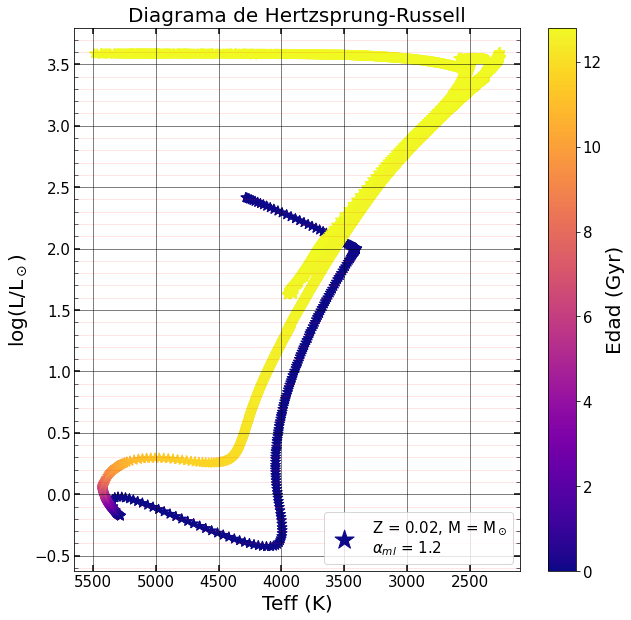

In [21]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(10 ** trimmed_history_alpha_1_2['log_Teff'], trimmed_history_alpha_1_2['log_L'], marker="*", s=100, c=trimmed_history_alpha_1_2['star_age'],
           cmap='plasma', label=r'Z = 0.02, M = M$_\odot$'+'\n'+ r'$\alpha_{ml}$ = 1.2')
ax.set_xlabel('Teff (K)', fontsize=20)
ax.xaxis.set_minor_locator(MultipleLocator(500))
ax.yaxis.set_minor_locator(MultipleLocator(0.1))
# colorbar for the age of the star
cbar = fig.colorbar(ax.scatter(10 ** trimmed_history_alpha_1_2['log_Teff'], trimmed_history_alpha_1_2['log_L'], marker="*", s=100, c=trimmed_history_alpha_1_2['star_age'], cmap='plasma'))
cbar.set_label('Edad (Gyr)', fontsize=20)
cbar.ax.tick_params(labelsize=15)

ax.invert_xaxis()

ax.tick_params(axis='both', labelsize=15, direction='in', right=True, top=True,
                length=6, width=1.5, grid_color='black', grid_alpha=1, grid_linestyle="-",
                grid_linewidth=0.5)

ax.tick_params(which='minor', length=4, color='black', direction='in', top=True, right=True,
                grid_alpha=0.2, grid_linewidth=0.5, grid_linestyle="-",grid_color='r')


ax.legend(fontsize=15, markerscale=2)
ax.grid(True, which='both')
ax.set_ylabel(r'log(L/L$_\odot$)', fontsize=20)
ax.set_title(r'Diagrama de Hertzsprung-Russell', fontsize=20)

# ALPHA 2.2

In [22]:
mesa_alpha_2_2_path = 'MESA_ALPHA_2_2'
trimmed_history_alpha_2_2 = read_history(os.path.join(mesa_alpha_2_2_path, 'trimmed_history.data'))
trimmed_history_alpha_2_2['star_age'] = np.array(trimmed_history_alpha_2_2['star_age']) * 10** -9
trimmed_history_alpha_2_2

{'version_number': '"12778"',
 'compiler': '"gfortran"',
 'build': '"9.2.0"',
 'MESA_SDK_version': '"x86_64-linux-20.3.2"',
 'math_backend': '"CRMATH"',
 'date': '"20231013"',
 'burn_min1': 50.0,
 'burn_min2': 1000.0,
 'model_number': array([    1,     2,     3, ..., 13654, 13655, 13656]),
 'star_age': array([1.00000000e-14, 2.20000000e-14, 3.64000000e-14, ...,
        2.81516007e+01, 2.81883385e+01, 2.81993598e+01]),
 'star_mass': array([1.        , 1.        , 1.        , ..., 0.56420136, 0.56420136,
        0.56420136]),
 'log_L': array([ 2.52906014,  2.52632316,  2.52286877, ..., -5.31387344,
        -5.31968754, -5.32143372]),
 'log_R': array([ 1.46840657,  1.46837962,  1.46834753, ..., -1.89727046,
        -1.8972707 , -1.89727067]),
 'log_Teff': array([3.65969117, 3.6590204 , 3.65817284, ..., 3.38179629, 3.38034288,
        3.37990632]),
 'log_center_T': array([5.47709382, 5.4770938 , 5.47709404, ..., 5.54479686, 5.54174122,
        5.54082186]),
 'log_center_Rho': array([-3.288

In [23]:
max(10 ** trimmed_history_alpha_2_2['log_Teff'])

125484.29253799366

Text(0.5, 1.0, 'Diagrama de Hertzsprung-Russell')

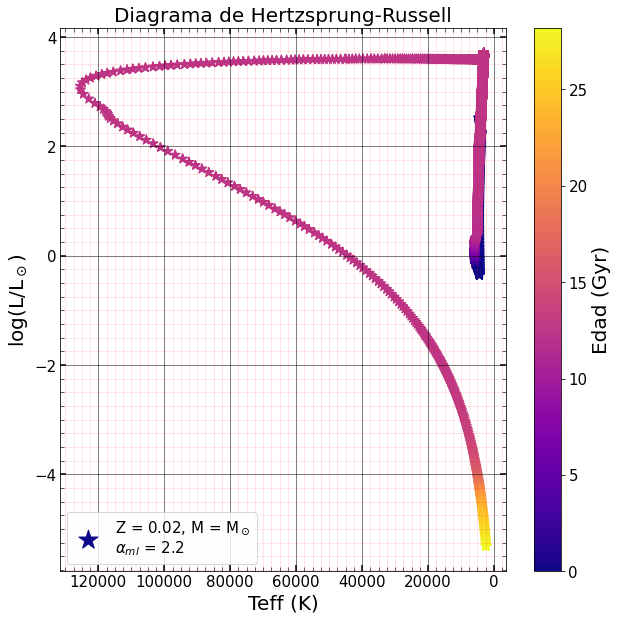

In [24]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(10 ** trimmed_history_alpha_2_2['log_Teff'], trimmed_history_alpha_2_2['log_L'], marker="*", s=100, c=trimmed_history_alpha_2_2['star_age'],
           cmap='plasma', label=r'Z = 0.02, M = M$_\odot$'+'\n'+ r'$\alpha_{ml}$ = 2.2')
ax.set_xlabel('Teff (K)', fontsize=20)
ax.xaxis.set_minor_locator(MultipleLocator(2500))
ax.yaxis.set_minor_locator(MultipleLocator(0.25))
# colorbar for the age of the star
cbar = fig.colorbar(ax.scatter(10 ** trimmed_history_alpha_2_2['log_Teff'], trimmed_history_alpha_2_2['log_L'], marker="*", s=100, c=trimmed_history_alpha_2_2['star_age'], cmap='plasma'))
cbar.set_label('Edad (Gyr)', fontsize=20)
cbar.ax.tick_params(labelsize=15)

ax.invert_xaxis()

ax.tick_params(axis='both', labelsize=15, direction='in', right=True, top=True,
                length=6, width=1.5, grid_color='black', grid_alpha=1, grid_linestyle="-",
                grid_linewidth=0.5)

ax.tick_params(which='minor', length=4, color='black', direction='in', top=True, right=True,
                grid_alpha=0.2, grid_linewidth=0.5, grid_linestyle="-",grid_color='r')


ax.legend(fontsize=15, markerscale=2)
ax.grid(True, which='both')
ax.set_ylabel(r'log(L/L$_\odot$)', fontsize=20)
ax.set_title(r'Diagrama de Hertzsprung-Russell', fontsize=20)